## 進階機器學習 HW5-3-2

* 學號: B103040047
* 姓名: 周安

In [49]:
# !pip install tqdm torchinfo

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
import pandas as pd
import os
import random
import itertools

# Check available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Train on {device}.")

Train on cuda.


Use `InfoGAN` to learn and replicate the data distribution.
* Input:
    * z (noise)
    * c (code)
* Generator `G`: gnerate target points.
* Descriminator `D`: differenate the generated result.
* classification model `Q`: predict the code.

In [51]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.04)   # 權重初始化為 N(0, 0.04)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)       # bias 初始為 0
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.04)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    """
    Input_point (x) shape: (N, x_dim)
    Input_lable (c_1) shape: (N, 1)
    Output shape: (N, out_dim)
    in_dim: distribution dim
    dim: hidden space's dim
    """
    def __init__(self, x_dim, num_class, out_dim, dim=64):
        super(Generator, self).__init__()
        self.input_dim = x_dim + num_class
        self.lin = nn.Sequential(
            nn.Linear(self.input_dim, dim),
            nn.ReLU(),
            nn.Linear(dim, out_dim),
            nn.Tanh(),
        )
        self.apply(weights_init)
    def forward(self, x, c_1):
        data = torch.cat((x, c_1), -1)
        out = 7 * self.lin(data) + 2 # [-1, 1] -> [-5, 9]
        return out
class Discriminator(nn.Module):
    """
    Input shape: (N, in_dim)
    Output_validity shape: (N, 1)
    Output_label  (c_1) shape: (N, 2)

    in_dim: distribution dim
    dim: hidden space's dim

    Q_head: predict the category label
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()
        self.lin = nn.Sequential(
            nn.Linear(in_dim, dim),
            nn.ReLU(),
        )
        # Output layers
        self.adv_layer = nn.Sequential(
            nn.Linear(dim, 1),
            # nn.ReLU(),
            # nn.Linear(32, 1),
            # nn.Sigmoid()# for BCELoss, WGAN don't need Sigmoid
        )
        self.aux_layer = nn.Sequential(
            nn.Linear(dim, 2),
            # nn.ReLU(),
            # nn.Linear(32, 2),
        )

        self.apply(weights_init)
    def forward(self, x):
        out = self.lin(x)
        validity = self.adv_layer(out) # real/fake
        label = self.aux_layer(out) # label 0/1
        return validity, label

## Initialization
* Create train dataset.
    * Two clusters with center (-3,-3) and (7,7)
* Due to InfoGAN, each point will bring a category number(0/1) as c_1 in dataset.

torch.Size([100000, 2]) torch.Size([100000])


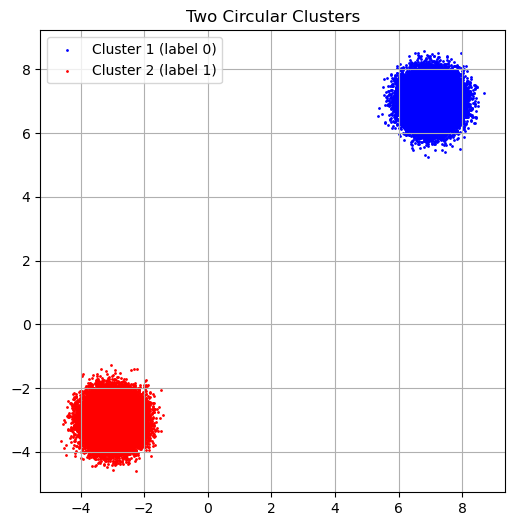

In [52]:
NUM_POINTS_PER_CLUSTER = 50000
BATCH_SIZE = 64
RANGE = 0.4
# Cluster 1: centered at (7, 7)
center_1 = np.array([7, 7])
radius_1 = RANGE  # Spread of the cluster
# Generate normally distributed points, scale by radius, and shift to center
points_1 = np.random.randn(NUM_POINTS_PER_CLUSTER, 2) * radius_1 + center_1

# Cluster 2: centered at (-3, -3)
center_2 = np.array([-3, -3])
radius_2 = RANGE
points_2 = np.random.randn(NUM_POINTS_PER_CLUSTER, 2) * radius_2 + center_2

# Combine both clusters into one dataset
X = np.vstack((points_1, points_2))
# Create corresponding labels: 0 for Cluster 1 (7, 7), 1 for Cluster 2 (-3, -3)
y = np.hstack((
    np.zeros(NUM_POINTS_PER_CLUSTER),
    np.ones(NUM_POINTS_PER_CLUSTER)
))

# create torch dateset and dataloader for training
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
print(X_tensor.shape, y_tensor.shape)

dot_dataset = TensorDataset(X_tensor, y_tensor)
dot_dataloader = DataLoader(dot_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Plot the dataset to visualize the two clusters
plt.figure(figsize=(6, 6))
plt.scatter(points_1[:, 0], points_1[:, 1], c='blue', label='Cluster 1 (label 0)', s=1)
plt.scatter(points_2[:, 0], points_2[:, 1], c='red', label='Cluster 2 (label 1)', s=1)
plt.legend()
plt.title('Two Circular Clusters')
plt.grid(True)
plt.axis('equal')  # Equal aspect ratio for X and Y axes
plt.show()

In [53]:
for x, y in dot_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([64, 2]) torch.Size([64])


In [54]:
def draw_scatter(points, c_1_sample):
    """
    points: (N, 2) numpy array
    c_1_sample: (N, 1) numpy array
    """
    # divide into two clusters
    points_c0 = points[c_1_sample.squeeze() == 0]
    points_c1 = points[c_1_sample.squeeze() == 1]

    # Plot the dataset
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.scatter(points_c0[:, 0], points_c0[:, 1], c='blue', label='c=0', alpha=0.5, s=1)
    ax.scatter(points_c1[:, 0], points_c1[:, 1], c='red', label='c=1', alpha=0.5, s=1)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    ax.set_aspect('equal')  # Equal aspect ratio for X and Y axes
    ax.set_title('Generated Points Distribution by c_1')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.legend(loc='upper left')
    return fig


In [55]:
# Training hyperparameters
z_dim = 2 # Gemerator input dim
z_sample = Variable(torch.randn(10000, z_dim) * 1).to(device) # show some generated points during training
c_1_sample = torch.randint(0, 2, (10000, 1), dtype=torch.long).to(device)
c_1_sample_onehot = F.one_hot(c_1_sample.squeeze(-1), num_classes=2).float()

LR = 1e-4
hidden_dim=5012 # hidden dim in generator
hidden_dim2=5012
NUM_EPOCHS = 50 # 50
n_critic = 2 # 5 # After train 5 steps discriminator, train generator once
clip_value = 0.01 # for WGAN
LAMBDA_INFO = 1 # ratio for info_loss in loss_G
# save path
log_dir = os.path.join("Training_Result", 'logs')
ckpt_dir = os.path.join("Training_Result", 'checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)


# Model
G = Generator(x_dim=z_dim, num_class=2, out_dim=2, dim=hidden_dim).to(device)
D = Discriminator(in_dim=2, dim=hidden_dim2).to(device)
G.train()
D.train()
# Loss
criterion = nn.BCELoss()
criterion_Q = nn.CrossEntropyLoss()
# Optimizer
# opt_D = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))
# opt_G = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
# opt_G = torch.optim.Adam([{'params': G.parameters()}, {'params': D.aux_layer.parameters()}], lr=LR, betas=(0.5, 0.999))
''' Use RMSprop for WGAN. '''
opt_D = torch.optim.RMSprop(D.parameters(), lr=LR)
# opt_G = torch.optim.RMSprop(G.parameters(), lr=LR)
opt_G = torch.optim.RMSprop([{'params': G.parameters()}, {'params': D.aux_layer.parameters()}], lr=LR)

# See the model structure
summary(G, [(1, z_dim), (1, 2)])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 5012]                 25,060
│    └─ReLU: 2-2                         [1, 5012]                 --
│    └─Linear: 2-3                       [1, 2]                    10,026
│    └─Tanh: 2-4                         [1, 2]                    --
Total params: 35,086
Trainable params: 35,086
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.14
Estimated Total Size (MB): 0.18

In [56]:
summary(D, (1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 5012]                 --
│    └─Linear: 2-1                       [1, 5012]                 15,036
│    └─ReLU: 2-2                         [1, 5012]                 --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-3                       [1, 1]                    5,013
├─Sequential: 1-3                        [1, 2]                    --
│    └─Linear: 2-4                       [1, 2]                    10,026
Total params: 30,075
Trainable params: 30,075
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.12
Estimated Total Size (MB): 0.16

In [57]:
def plt_loss_accuracy_fig(Total_training_loss):
    # visualization the loss and accuracy
    plt.figure()
    plt.plot(range(len(Total_training_loss)), Total_training_loss, 'b-', label='Training_loss')
    plt.title('Training loss')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [58]:
for param in G.parameters():
    print(param.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


Initial generated result. (Before training)

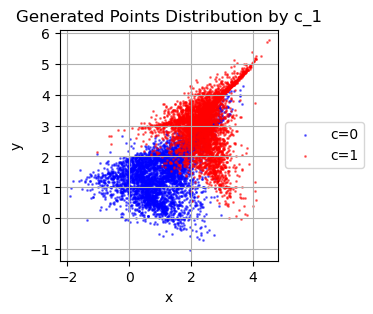

Generator(
  (lin): Sequential(
    (0): Linear(in_features=4, out_features=5012, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5012, out_features=2, bias=True)
    (3): Tanh()
  )
)

In [59]:
G.eval()
f_points_sample= G(z_sample, c_1_sample_onehot)
fig = draw_scatter(f_points_sample.cpu().detach().numpy(), c_1_sample.cpu().detach().numpy())
plt.show()
plt.close(fig)
G.train()

100%|██████████| 1563/1563 [00:05<00:00, 308.82it/s]


Epoch[ 1/50] : Generator Loss = 0.6379, Info Loss = 0.6307, Descriminator Loss = -0.0632


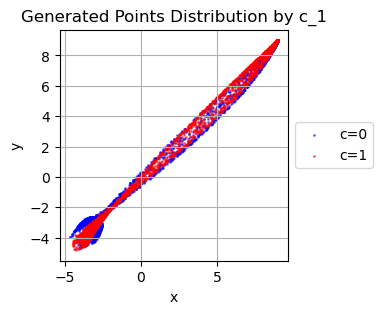

	| Save distribution image to Training_Result\logs\Epoch_001.jpg.


100%|██████████| 1563/1563 [00:04<00:00, 321.52it/s]


Epoch[ 2/50] : Generator Loss = 0.8965, Info Loss = 0.5554, Descriminator Loss = -0.0091


100%|██████████| 1563/1563 [00:04<00:00, 321.73it/s]


Epoch[ 3/50] : Generator Loss = 1.6406, Info Loss = 0.5326, Descriminator Loss = -0.0530


100%|██████████| 1563/1563 [00:05<00:00, 290.89it/s]


Epoch[ 4/50] : Generator Loss = 1.8592, Info Loss = 0.4952, Descriminator Loss = -0.1067


100%|██████████| 1563/1563 [00:05<00:00, 297.15it/s]


Epoch[ 5/50] : Generator Loss = 2.0900, Info Loss = 0.4457, Descriminator Loss = -0.1339


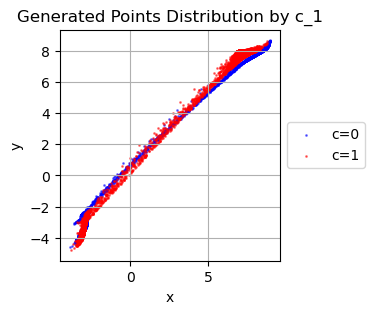

	| Save distribution image to Training_Result\logs\Epoch_005.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 307.04it/s]


Epoch[ 6/50] : Generator Loss = 2.1049, Info Loss = 0.3991, Descriminator Loss = -0.1223


100%|██████████| 1563/1563 [00:05<00:00, 303.78it/s]


Epoch[ 7/50] : Generator Loss = 2.2471, Info Loss = 0.3414, Descriminator Loss = -0.1131


100%|██████████| 1563/1563 [00:05<00:00, 310.08it/s]


Epoch[ 8/50] : Generator Loss = 2.4469, Info Loss = 0.3130, Descriminator Loss = -0.1051


100%|██████████| 1563/1563 [00:04<00:00, 312.78it/s]


Epoch[ 9/50] : Generator Loss = 2.6583, Info Loss = 0.3354, Descriminator Loss = -0.1036


100%|██████████| 1563/1563 [00:05<00:00, 310.73it/s]


Epoch[10/50] : Generator Loss = 2.6448, Info Loss = 0.3167, Descriminator Loss = -0.1013


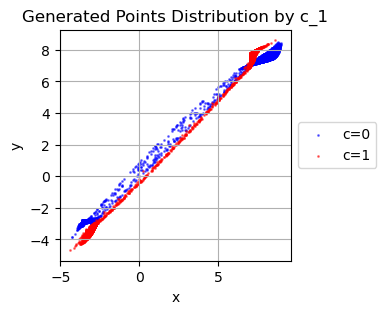

	| Save distribution image to Training_Result\logs\Epoch_010.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 306.34it/s]


Epoch[11/50] : Generator Loss = 2.7333, Info Loss = 0.3178, Descriminator Loss = -0.1001


100%|██████████| 1563/1563 [00:05<00:00, 299.54it/s]


Epoch[12/50] : Generator Loss = 2.8731, Info Loss = 0.3338, Descriminator Loss = -0.0943


100%|██████████| 1563/1563 [00:05<00:00, 305.55it/s]


Epoch[13/50] : Generator Loss = 2.9224, Info Loss = 0.3384, Descriminator Loss = -0.0926


100%|██████████| 1563/1563 [00:05<00:00, 298.72it/s]


Epoch[14/50] : Generator Loss = 3.0013, Info Loss = 0.3525, Descriminator Loss = -0.0929


100%|██████████| 1563/1563 [00:05<00:00, 293.65it/s]


Epoch[15/50] : Generator Loss = 3.0155, Info Loss = 0.3203, Descriminator Loss = -0.0899


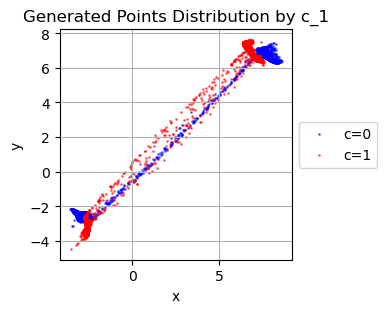

	| Save distribution image to Training_Result\logs\Epoch_015.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 302.87it/s]


Epoch[16/50] : Generator Loss = 3.1515, Info Loss = 0.3176, Descriminator Loss = -0.0903


100%|██████████| 1563/1563 [00:04<00:00, 316.73it/s]


Epoch[17/50] : Generator Loss = 3.2795, Info Loss = 0.3311, Descriminator Loss = -0.0895


100%|██████████| 1563/1563 [00:05<00:00, 294.99it/s]


Epoch[18/50] : Generator Loss = 3.2775, Info Loss = 0.3316, Descriminator Loss = -0.0890


100%|██████████| 1563/1563 [00:05<00:00, 310.93it/s]


Epoch[19/50] : Generator Loss = 3.3192, Info Loss = 0.3130, Descriminator Loss = -0.0874


100%|██████████| 1563/1563 [00:04<00:00, 313.12it/s]


Epoch[20/50] : Generator Loss = 3.3642, Info Loss = 0.3200, Descriminator Loss = -0.0885


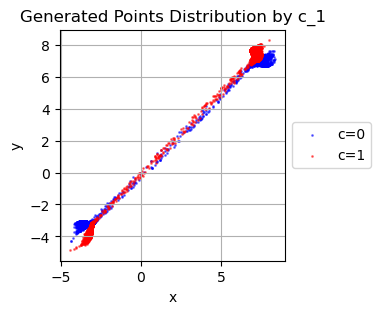

	| Save distribution image to Training_Result\logs\Epoch_020.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 294.98it/s]


Epoch[21/50] : Generator Loss = 3.5281, Info Loss = 0.3471, Descriminator Loss = -0.0849


100%|██████████| 1563/1563 [00:05<00:00, 297.56it/s]


Epoch[22/50] : Generator Loss = 3.4288, Info Loss = 0.3051, Descriminator Loss = -0.0851


100%|██████████| 1563/1563 [00:05<00:00, 305.16it/s]


Epoch[23/50] : Generator Loss = 3.4605, Info Loss = 0.2877, Descriminator Loss = -0.0834


100%|██████████| 1563/1563 [00:05<00:00, 300.17it/s]


Epoch[24/50] : Generator Loss = 3.5765, Info Loss = 0.2888, Descriminator Loss = -0.0833


100%|██████████| 1563/1563 [00:05<00:00, 295.22it/s]


Epoch[25/50] : Generator Loss = 3.6041, Info Loss = 0.2776, Descriminator Loss = -0.0854


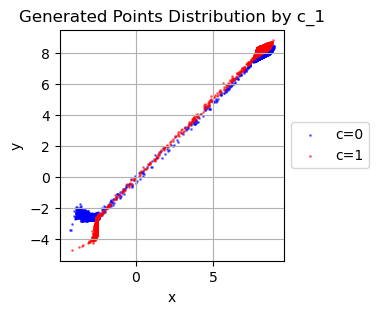

	| Save distribution image to Training_Result\logs\Epoch_025.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 289.52it/s]


Epoch[26/50] : Generator Loss = 3.7143, Info Loss = 0.3017, Descriminator Loss = -0.0810


100%|██████████| 1563/1563 [00:05<00:00, 309.20it/s]


Epoch[27/50] : Generator Loss = 3.7584, Info Loss = 0.2669, Descriminator Loss = -0.0878


100%|██████████| 1563/1563 [00:05<00:00, 298.71it/s]


Epoch[28/50] : Generator Loss = 3.7310, Info Loss = 0.2552, Descriminator Loss = -0.0862


100%|██████████| 1563/1563 [00:05<00:00, 292.80it/s]


Epoch[29/50] : Generator Loss = 3.7934, Info Loss = 0.2541, Descriminator Loss = -0.0861


100%|██████████| 1563/1563 [00:05<00:00, 291.27it/s]


Epoch[30/50] : Generator Loss = 3.7624, Info Loss = 0.2569, Descriminator Loss = -0.0827


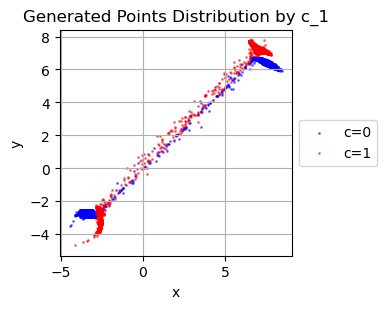

	| Save distribution image to Training_Result\logs\Epoch_030.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 292.49it/s]


Epoch[31/50] : Generator Loss = 3.8644, Info Loss = 0.2876, Descriminator Loss = -0.0825


100%|██████████| 1563/1563 [00:05<00:00, 310.35it/s]


Epoch[32/50] : Generator Loss = 4.1798, Info Loss = 0.3094, Descriminator Loss = -0.0822


100%|██████████| 1563/1563 [00:04<00:00, 317.69it/s]


Epoch[33/50] : Generator Loss = 4.2275, Info Loss = 0.2911, Descriminator Loss = -0.0816


100%|██████████| 1563/1563 [00:04<00:00, 315.83it/s]


Epoch[34/50] : Generator Loss = 3.9163, Info Loss = 0.2608, Descriminator Loss = -0.0815


100%|██████████| 1563/1563 [00:05<00:00, 306.65it/s]


Epoch[35/50] : Generator Loss = 4.0496, Info Loss = 0.2973, Descriminator Loss = -0.0828


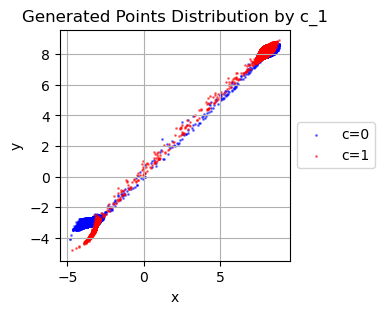

	| Save distribution image to Training_Result\logs\Epoch_035.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 309.57it/s]


Epoch[36/50] : Generator Loss = 4.0039, Info Loss = 0.2602, Descriminator Loss = -0.0849


100%|██████████| 1563/1563 [00:04<00:00, 320.59it/s]


Epoch[37/50] : Generator Loss = 4.1193, Info Loss = 0.2552, Descriminator Loss = -0.0791


100%|██████████| 1563/1563 [00:04<00:00, 312.65it/s]


Epoch[38/50] : Generator Loss = 4.0898, Info Loss = 0.2598, Descriminator Loss = -0.0772


100%|██████████| 1563/1563 [00:05<00:00, 304.93it/s]


Epoch[39/50] : Generator Loss = 4.1035, Info Loss = 0.2444, Descriminator Loss = -0.0769


100%|██████████| 1563/1563 [00:05<00:00, 308.71it/s]


Epoch[40/50] : Generator Loss = 4.2830, Info Loss = 0.2706, Descriminator Loss = -0.0769


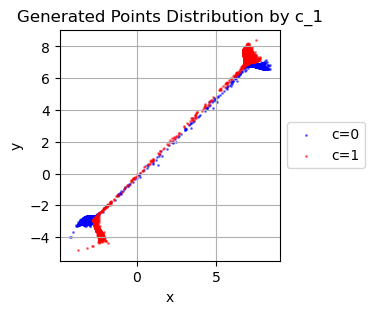

	| Save distribution image to Training_Result\logs\Epoch_040.jpg.


100%|██████████| 1563/1563 [00:05<00:00, 303.68it/s]


Epoch[41/50] : Generator Loss = 4.1948, Info Loss = 0.2375, Descriminator Loss = -0.0800


100%|██████████| 1563/1563 [00:05<00:00, 311.16it/s]


Epoch[42/50] : Generator Loss = 4.1605, Info Loss = 0.2067, Descriminator Loss = -0.0758


100%|██████████| 1563/1563 [00:04<00:00, 318.54it/s]


Epoch[43/50] : Generator Loss = 4.2507, Info Loss = 0.2262, Descriminator Loss = -0.0780


100%|██████████| 1563/1563 [00:05<00:00, 294.96it/s]


Epoch[44/50] : Generator Loss = 4.2486, Info Loss = 0.2163, Descriminator Loss = -0.0788


100%|██████████| 1563/1563 [00:05<00:00, 303.38it/s]


Epoch[45/50] : Generator Loss = 4.3052, Info Loss = 0.2241, Descriminator Loss = -0.0803


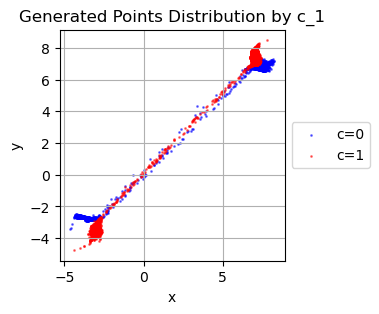

	| Save distribution image to Training_Result\logs\Epoch_045.jpg.


100%|██████████| 1563/1563 [00:04<00:00, 317.87it/s]


Epoch[46/50] : Generator Loss = 4.6297, Info Loss = 0.2446, Descriminator Loss = -0.0793


100%|██████████| 1563/1563 [00:05<00:00, 311.40it/s]


Epoch[47/50] : Generator Loss = 4.4153, Info Loss = 0.2364, Descriminator Loss = -0.0777


100%|██████████| 1563/1563 [00:05<00:00, 304.96it/s]


Epoch[48/50] : Generator Loss = 4.2861, Info Loss = 0.2044, Descriminator Loss = -0.0724


100%|██████████| 1563/1563 [00:05<00:00, 303.29it/s]


Epoch[49/50] : Generator Loss = 4.3396, Info Loss = 0.1947, Descriminator Loss = -0.0842


100%|██████████| 1563/1563 [00:05<00:00, 304.77it/s]


Epoch[50/50] : Generator Loss = 4.4237, Info Loss = 0.2020, Descriminator Loss = -0.0730


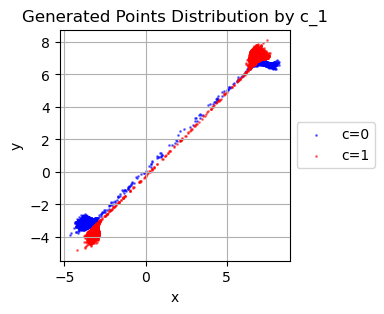

	| Save distribution image to Training_Result\logs\Epoch_050.jpg.


In [60]:
from tqdm import tqdm

# Start training and testing
best_loss = 1000
# For ploting the trend image
total_train_loss_G = list()
total_train_loss_D = list()
total_train_loss_info = list()
for epoc in range(NUM_EPOCHS):
    train_loss_G = list()
    train_loss_D = list()
    train_loss_info = list()
    progress_bar = tqdm(dot_dataloader)
    for i, (x, _) in enumerate(progress_bar):
        ''' train D '''
        r_point = x.to(device)
        # random noise
        z = Variable(torch.randn(x.shape[0], z_dim)).to(device)
        c_1 = torch.randint(0, 2, (x.shape[0], 1), dtype=torch.long).to(device)
        c_1_onehot = F.one_hot(c_1.squeeze(-1), num_classes=2).float()


        f_point = G(z, c_1_onehot) # output shape is (batch_size, 2)
        # prepare value for loss function
        r_label = Variable(torch.ones(x.shape[0], 1)).to(device) # real: 1
        f_label = Variable(torch.zeros(x.shape[0], 1)).to(device) # fake: 0

        # # Forward D
        # r_logit, _ = D(r_point.detach())
        # f_logit, _ = D(f_point.detach())

        # # GAN Loss
        # r_loss = criterion(r_logit, r_label)
        # f_loss = criterion(f_logit, f_label)
        # loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        loss_D = -torch.mean(D(r_point)[0]) + torch.mean(D(f_point)[0])

        # Model backwarding
        opt_D.zero_grad()
        loss_D.backward()

        # Update the descriminator.
        opt_D.step()

        train_loss_D.append(loss_D.item())

        """ Clip weights of discriminator. """
        for p in D.adv_layer.parameters():
           p.data.clamp_(-clip_value, clip_value)

        ''' train G '''
        if i % n_critic == 0:
            # random noise
            z = Variable(torch.randn(x.shape[0], z_dim)).to(device)
            c_1 = torch.randint(0, 2, (x.shape[0], 1), dtype=torch.long).to(device)
            c_1_onehot = F.one_hot(c_1.squeeze(-1), num_classes=2).float()

            f_point = G(z, c_1_onehot) # output shape is (batch_size, 2)

            f_logit, f_c_1 = D(f_point.detach())
            # GAN Loss
            loss_info = criterion_Q(f_c_1, c_1.squeeze(-1))
            # loss_G = criterion(f_logit, r_label) + LAMBDA_INFO * loss_info

            # WGAN Loss
            loss_G = -torch.mean(D(f_point)[0]) + LAMBDA_INFO * loss_info

            # Model backwarding
            opt_G.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()

            train_loss_G.append(loss_G.item())
            train_loss_info.append(loss_info.item())

    mean_loss_D = np.mean(train_loss_D)
    mean_loss_G = np.mean(train_loss_G)
    mean_loss_info = np.mean(train_loss_info)
    # record the training data
    total_train_loss_D.append(mean_loss_D)
    total_train_loss_G.append(mean_loss_G)
    total_train_loss_info.append(mean_loss_info)
    print("Epoch[{:>2d}/{:>2d}] : Generator Loss = {:.4f}, Info Loss = {:.4f}, Descriminator Loss = {:.4f}".format(epoc+1, NUM_EPOCHS, mean_loss_G, mean_loss_info, mean_loss_D))

    if (epoc+1) % 5 == 0 or epoc == 0:
        G.eval()
        f_points_sample = G(z_sample, c_1_sample_onehot)
        fig = draw_scatter(f_points_sample.cpu().detach().numpy(), c_1_sample.cpu().detach().numpy())
        filename = os.path.join(log_dir, f'Epoch_{epoc+1:03d}.jpg')
        fig.savefig(filename, dpi=300)
        plt.show()
        plt.close(fig)
        print(f'\t| Save distribution image to {filename}.')

        G.train()
    # Save the checkpoints.
    torch.save(D.state_dict(), os.path.join(ckpt_dir, 'D.pth'))
    if (epoc+1) % 5 == 0:
        torch.save(G.state_dict(), os.path.join(ckpt_dir, 'G.pth'))

Generator training Process


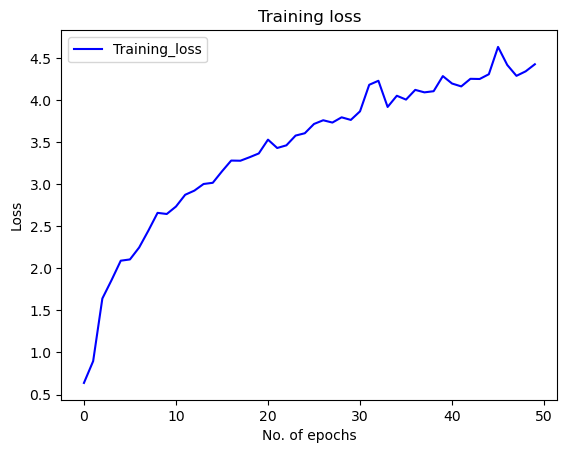

In [61]:
print("Generator training Process")
plt_loss_accuracy_fig(total_train_loss_G)

Descriminator training Process


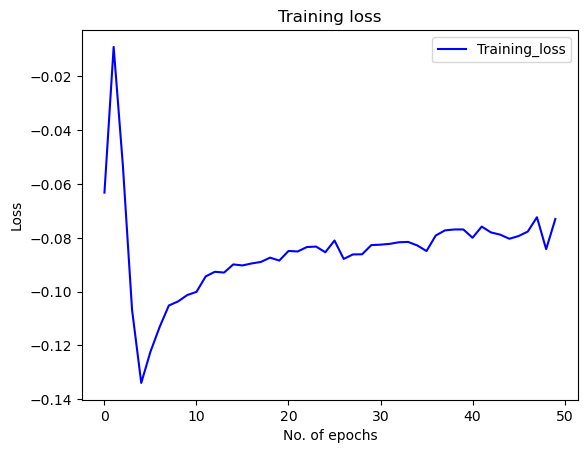

In [62]:
print("Descriminator training Process")
plt_loss_accuracy_fig(total_train_loss_D)

Descriminator training Process


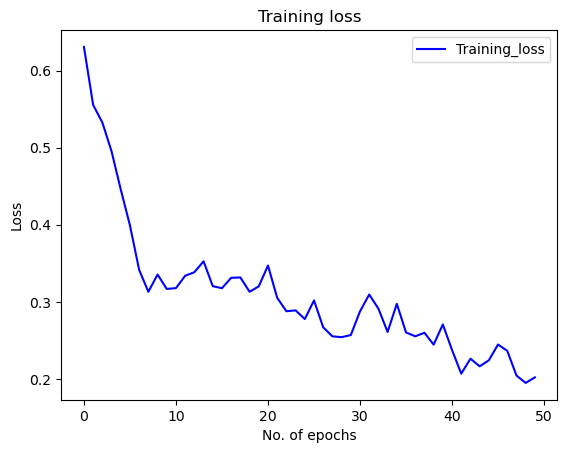

In [63]:
print("Descriminator training Process")
plt_loss_accuracy_fig(total_train_loss_info)

Generated from `z_sample` which is the same as the one tested during training.

In [64]:
def draw_scatter_mark_center(points, c_1_sample):
    """
    points: (N, 2) numpy array
    c_1_sample: (N, 1) numpy array
    """
    # divide into two clusters
    points_c0 = points[c_1_sample.squeeze() == 0]
    points_c1 = points[c_1_sample.squeeze() == 1]

    # Plot the dataset
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.scatter(points_c0[:, 0], points_c0[:, 1], c='blue', label='c=0', alpha=0.5, s=1)
    ax.scatter(points_c1[:, 0], points_c1[:, 1], c='red', label='c=1', alpha=0.5, s=1)

    # Mark the cluster centers
    centers = np.array([[7, 7], [-3, -3]])
    ax.scatter(centers[0, 0], centers[0, 1], c='yellow', s=50, marker='x', label='Ideal Centers (7,7)')
    ax.scatter(centers[1, 0], centers[1, 1], c='pink', s=50, marker='x', label='Ideal Centers (-3,-3)')


    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    ax.set_aspect('equal')  # Equal aspect ratio for X and Y axes
    ax.set_title('Generated Points Distribution by c_1')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.legend(loc='upper left')
    return fig

Load pth from Training_Result\checkpoints\G.pth


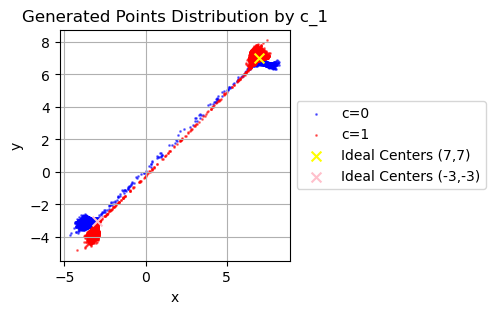

In [65]:
G = Generator(x_dim=z_dim, num_class=2, out_dim=2, dim=hidden_dim).to(device)
pth_path = os.path.join(ckpt_dir, 'G.pth')
state_dict = torch.load(pth_path)
G.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")
G.eval()

f_points_sample = G(z_sample, c_1_sample_onehot)
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy(), c_1_sample.cpu().detach().numpy())
plt.show()
plt.close(fig)

Generated from **new samples**.

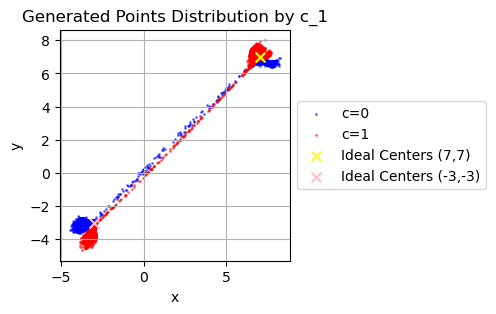

In [66]:
generated_points = 10000
c_1 = torch.randint(0, 2, (generated_points, 1), dtype=torch.long).to(device)
c_1_onehot = F.one_hot(c_1.squeeze(-1), num_classes=2).float()

f_points_sample = G(Variable(torch.randn(generated_points, z_dim) * 1).to(device), c_1_onehot)
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy(), c_1.cpu().detach().numpy())
plt.show()
plt.close(fig)

---
#### i. Control the categorical input to specify which group (cluster) of data to generate.
#### ii. Plot and demonstrate how the model can generate data from each specific cluster by manipulating the categorical variable.


In [68]:
G = Generator(x_dim=z_dim, num_class=2, out_dim=2, dim=hidden_dim).to(device)
pth_path = os.path.join(ckpt_dir, 'G.pth')
state_dict = torch.load(pth_path)
G.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")
G.eval()

Load pth from Training_Result\checkpoints\G.pth


Generator(
  (lin): Sequential(
    (0): Linear(in_features=4, out_features=5012, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5012, out_features=2, bias=True)
    (3): Tanh()
  )
)

#### Draw cluster 0.
* using `torch.zeros`


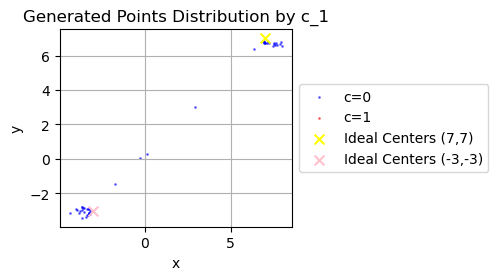

In [70]:
generated_points = 50
c_1 = torch.zeros(generated_points, 1, dtype=torch.long).to(device)
c_1_onehot = F.one_hot(c_1.squeeze(-1), num_classes=2).float()

f_points_sample = G(Variable(torch.randn(generated_points, z_dim) * 1).to(device), c_1_onehot)
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy(), c_1.cpu().detach().numpy())
plt.show()
plt.close(fig)

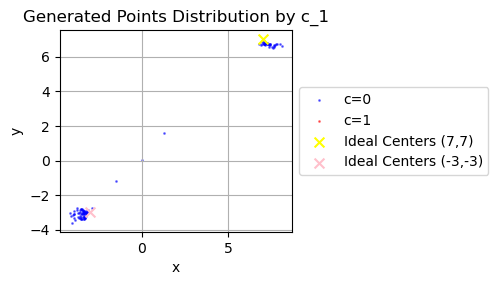

In [82]:
generated_points = 100
c_1 = torch.zeros(generated_points, 1, dtype=torch.long).to(device)
c_1_onehot = F.one_hot(c_1.squeeze(-1), num_classes=2).float()

f_points_sample = G(Variable(torch.randn(generated_points, z_dim) * 1).to(device), c_1_onehot)
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy(), c_1.cpu().detach().numpy())
plt.show()
plt.close(fig)

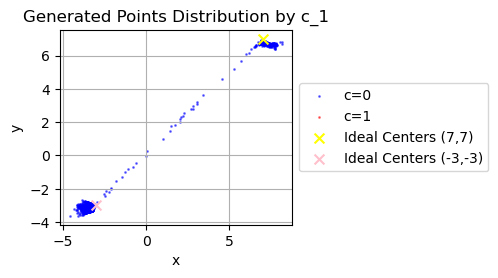

In [72]:
generated_points = 1000
c_1 = torch.zeros(generated_points, 1, dtype=torch.long).to(device)
c_1_onehot = F.one_hot(c_1.squeeze(-1), num_classes=2).float()

f_points_sample = G(Variable(torch.randn(generated_points, z_dim) * 1).to(device), c_1_onehot)
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy(), c_1.cpu().detach().numpy())
plt.show()
plt.close(fig)

#### Draw cluster 1.
* using `torch.ones`

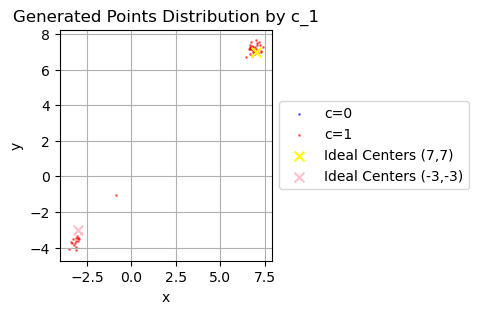

In [73]:
generated_points = 50
c_1 = torch.ones(generated_points, 1, dtype=torch.long).to(device)
c_1_onehot = F.one_hot(c_1.squeeze(-1), num_classes=2).float()

f_points_sample = G(Variable(torch.randn(generated_points, z_dim) * 1).to(device), c_1_onehot)
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy(), c_1.cpu().detach().numpy())
plt.show()
plt.close(fig)

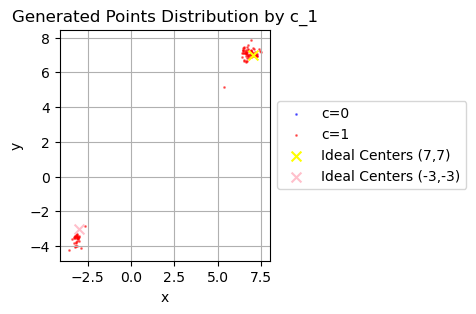

In [76]:
generated_points = 100
c_1 = torch.ones(generated_points, 1, dtype=torch.long).to(device)
c_1_onehot = F.one_hot(c_1.squeeze(-1), num_classes=2).float()

f_points_sample = G(Variable(torch.randn(generated_points, z_dim) * 1).to(device), c_1_onehot)
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy(), c_1.cpu().detach().numpy())
plt.show()
plt.close(fig)

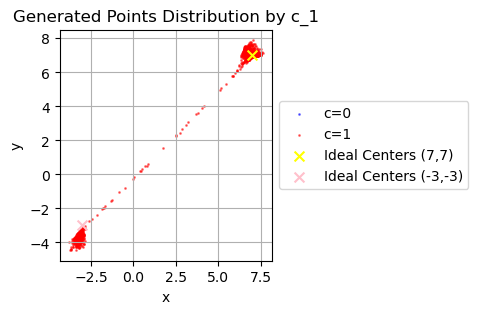

In [80]:
generated_points = 1000
c_1 = torch.ones(generated_points, 1, dtype=torch.long).to(device)
c_1_onehot = F.one_hot(c_1.squeeze(-1), num_classes=2).float()

f_points_sample = G(Variable(torch.randn(generated_points, z_dim) * 1).to(device), c_1_onehot)
fig = draw_scatter_mark_center(f_points_sample.cpu().detach().numpy(), c_1.cpu().detach().numpy())
plt.show()
plt.close(fig)